# TFM: Impacto del aumento de datos en histopatología de cáncer de mama
## 1. Análisis Exploratorio de Datos (EDA) y Preprocesamiento

**Autor:** Sergio Elies  
**Descripción:** Este notebook documenta el proceso de gestión de datos del proyecto.
1.  **Histórico:** Código de referencia utilizado para transformar las imágenes raw (Google Cloud) a tensores `.npz`.
2.  **Análisis:** Carga del dataset procesado y estadísticas de desbalance.
3.  **Validación del Split:** Demostración de la estrategia de particionado por paciente.
4.  **Visualización:** Muestras del dataset y demostración técnica de las estrategias de aumentación.

In [ ]:
# =======================================================
# 0. HISTÓRICO: OBTENCIÓN DE DATOS DESDE GOOGLE CLOUD (REFERENCIA)
# =======================================================
# Este bloque estaba destinado a conectar con Google Cloud Storage y
# transformar las imágenes originales del bucket en formato .npz por paciente.
# Ya no es necesario porque el dataset procesado se encuentra disponible
# en los inputs del repositorio.

'''
# INSTALAR Y CONFIGURAR GOOGLE CLOUD CLIENT
!pip install --quiet google-cloud-storage matplotlib pillow

from google.cloud import storage
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/kaggle/input/gcp-access/gcp.json"

BUCKET_NAME = "tfm_data_science"
PREFIXES = [
    "breast_images/benign/SOB/",
    "breast_images/malign/SOB/"
]

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)

# =======================================================
# TRANSFORMAR IMÁGENES 200X en MATRICES NUMPY Y GUARDAR POR PACIENTE
# =======================================================
from tqdm import tqdm
IMG_SIZE = (224, 224)
LOCAL_DIR = "/kaggle/working/breakhis_200x_npz"
os.makedirs(LOCAL_DIR, exist_ok=True)

def preprocess_image(image_bytes):
    img = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    img = img.resize(IMG_SIZE)
    return np.asarray(img, dtype=np.float32) / 255.0

patients_data = {}

for prefix in PREFIXES:
    cls = "benign" if "benign" in prefix else "malign"
    for blob in tqdm(bucket.list_blobs(prefix=prefix), desc=f"Leyendo {cls}"):
        if "/200X/" in blob.name and blob.name.endswith(".png"):
            parts = blob.name.split("/")
            sob_folder = next((p for p in parts if p.startswith("SOB_")), None)
            tumor_type = parts[3] if len(parts) > 3 else "unknown"
            if sob_folder is None:
                continue
            patient_id = sob_folder.split("_")[-1][3:]
            key = (cls, patient_id, tumor_type)
            if key not in patients_data:
                patients_data[key] = []
            img_bytes = blob.download_as_bytes()
            img_arr = preprocess_image(img_bytes)
            patients_data[key].append(img_arr)

for (cls, patient_id, tumor_type), imgs in patients_data.items():
    arr = np.stack(imgs, axis=0)
    np.savez_compressed(
        os.path.join(LOCAL_DIR, f"{cls}_{tumor_type}_{patient_id}.npz"),
        images=arr, label=cls, tumor_type=tumor_type, patient_id=patient_id
    )

import shutil
shutil.make_archive("/kaggle/working/breakhis_200x_npz", 'zip', LOCAL_DIR)
'''

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import torchvision.transforms.functional as F
import torchvision.transforms as T
from sklearn.model_selection import GroupShuffleSplit

# ==============================================================================
# CONFIGURACIÓN DE RUTAS
# ==============================================================================
# Ajustar esta ruta a la ubicación de los archivos .npz en el repositorio
DATA_PATH = "./data/breakhis_npz" 

if not os.path.exists(DATA_PATH):
    print(f"La ruta '{DATA_PATH}' no existe. Ajusta la variable DATA_PATH.")
else:
    print(f"Directorio de datos detectado: {DATA_PATH}")

Directorio de datos detectado: /kaggle/input/breakhis


In [3]:
# ==============================================================================
# 1. CARGA DE METADATOS Y ANÁLISIS DE DESBALANCE
# ==============================================================================

files = [f for f in os.listdir(DATA_PATH) if f.endswith(".npz")]

rows = []
for f in files:
    parts = f.replace(".npz", "").split("_")
    ttype = parts[0]
    pid = parts[-1]
    subtype = "_".join(parts[1:-1])
    
    # Carga ligera para obtener conteos
    arr = np.load(os.path.join(DATA_PATH, f))
    imgs = arr[list(arr.keys())[0]]
    rows.append((ttype, subtype, pid, imgs.shape[0]))

df = pd.DataFrame(rows, columns=["TumorType", "Subtype", "PatientID", "NumImages"])

# Resultados Numéricos
print(f"🧍 Pacientes Totales: {len(df)}")
print(f"🖼️ Imágenes Totales:  {df['NumImages'].sum()}")
print(f"📈 Promedio img/paciente: {df['NumImages'].mean():.1f}\n")

print("--- Desglose por Clase (Pacientes e Imágenes) ---")
print(df.groupby("TumorType")
      .agg(Pacientes=('PatientID','count'),
           Imagenes=('NumImages','sum'),
           Media_img_paciente=('NumImages','mean'))
      .round(1)
      .to_string())

print("\n--- Desglose por Subtipo Histológico ---")
print(df.groupby(["TumorType","Subtype"])
      .agg(Pacientes=('PatientID','count'),
           Imagenes=('NumImages','sum'))
      .sort_values("Imagenes", ascending=False)
      .reset_index()
      .to_string(index=False))

🧍 Pacientes Totales: 82
🖼️ Imágenes Totales:  2013
📈 Promedio img/paciente: 24.5

--- Desglose por Clase (Pacientes e Imágenes) ---
           Pacientes  Imagenes  Media_img_paciente
TumorType                                         
benign            24       623                26.0
malign            58      1390                24.0

--- Desglose por Subtipo Histológico ---
TumorType             Subtype  Pacientes  Imagenes
   malign    ductal_carcinoma         38       896
   benign        fibroadenoma         10       264
   malign  mucinous_carcinoma          9       196
   malign   lobular_carcinoma          5       163
   benign     tubular_adenoma          7       140
   malign papillary_carcinoma          6       135
   benign            adenosis          4       111
   benign     phyllodes_tumor          3       108


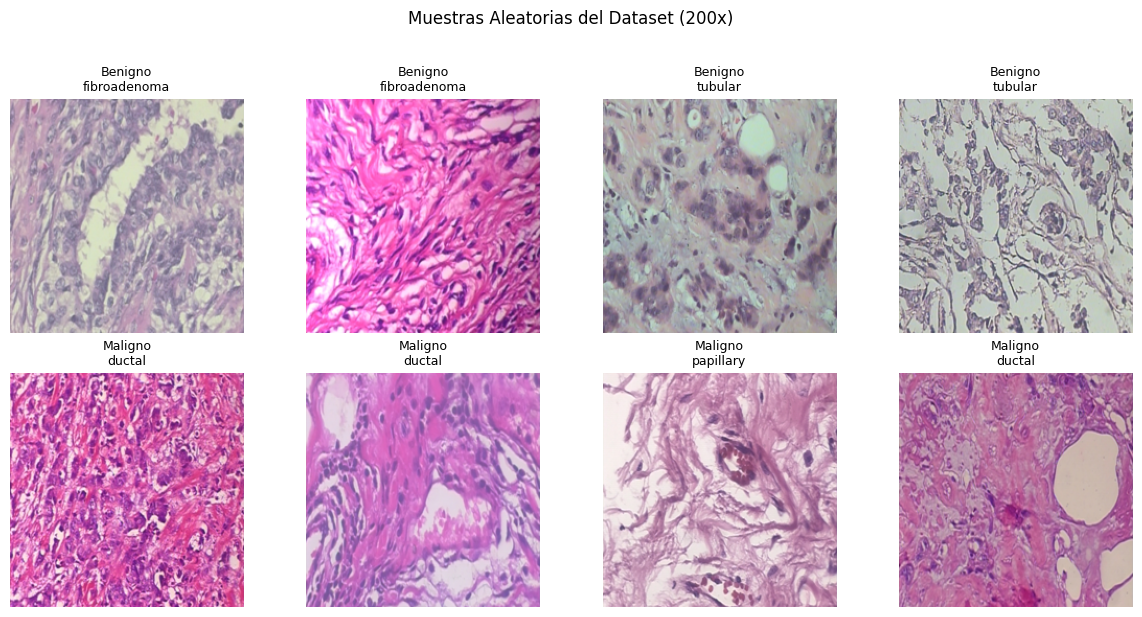

In [4]:
# ==============================================================================
# 2. VISUALIZACIÓN DE MUESTRAS DEL DATASET
# ==============================================================================
def load_first_image(file): 
    arr = np.load(os.path.join(DATA_PATH, file))
    return arr[list(arr.keys())[0]][0]

benign_samples = random.sample([f for f in files if f.startswith("benign_")], 4)
malign_samples = random.sample([f for f in files if f.startswith("malign_")], 4)

fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, f in enumerate(benign_samples):
    ax[0,i].imshow(load_first_image(f))
    ax[0,i].set_title(f"Benigno\n{f.split('_')[1]}", fontsize=9)
    ax[0,i].axis("off")

for i, f in enumerate(malign_samples):
    ax[1,i].imshow(load_first_image(f))
    ax[1,i].set_title(f"Maligno\n{f.split('_')[1]}", fontsize=9)
    ax[1,i].axis("off")

plt.suptitle("Muestras Aleatorias del Dataset (200x)", y=1.02)
plt.tight_layout()
plt.show()

In [5]:
# ==============================================================================
# 3. VERIFICACIÓN DE LA ESTRATEGIA DE PARTICIONADO
# ==============================================================================
# Se demuestra que el particionado respeta la agrupación por paciente
# para evitar Data Leakage.

# 1. Split Train+Val / Test (15% Test)
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=3)
train_val_idx, test_idx = next(gss.split(df, df["TumorType"], groups=df["PatientID"]))

train_val = df.iloc[train_val_idx]
test = df.iloc[test_idx]

# 2. Split Train / Val (15% Val sobre el restante)
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=3)
train_idx, val_idx = next(gss2.split(train_val, train_val["TumorType"], groups=train_val["PatientID"]))

train = train_val.iloc[train_idx]
val = train_val.iloc[val_idx]

def show_split_stats(subset_df, name):
    n_pat = subset_df.shape[0]
    n_img = subset_df['NumImages'].sum()
    dist = subset_df["TumorType"].value_counts(normalize=True).mul(100).round(1)
    print(f"[{name}] Pacientes: {n_pat} | Imágenes: {n_img}")
    print(f"   Distribución: {dist.to_dict()}")

print("--- Estadísticas del Particionado ---")
show_split_stats(train, "TRAIN")
show_split_stats(val, "VALIDATION")
show_split_stats(test, "TEST")

--- Estadísticas del Particionado ---
[TRAIN] Pacientes: 58 | Imágenes: 1419
   Distribución: {'malign': 70.7, 'benign': 29.3}
[VALIDATION] Pacientes: 11 | Imágenes: 331
   Distribución: {'malign': 72.7, 'benign': 27.3}
[TEST] Pacientes: 13 | Imágenes: 263
   Distribución: {'malign': 69.2, 'benign': 30.8}


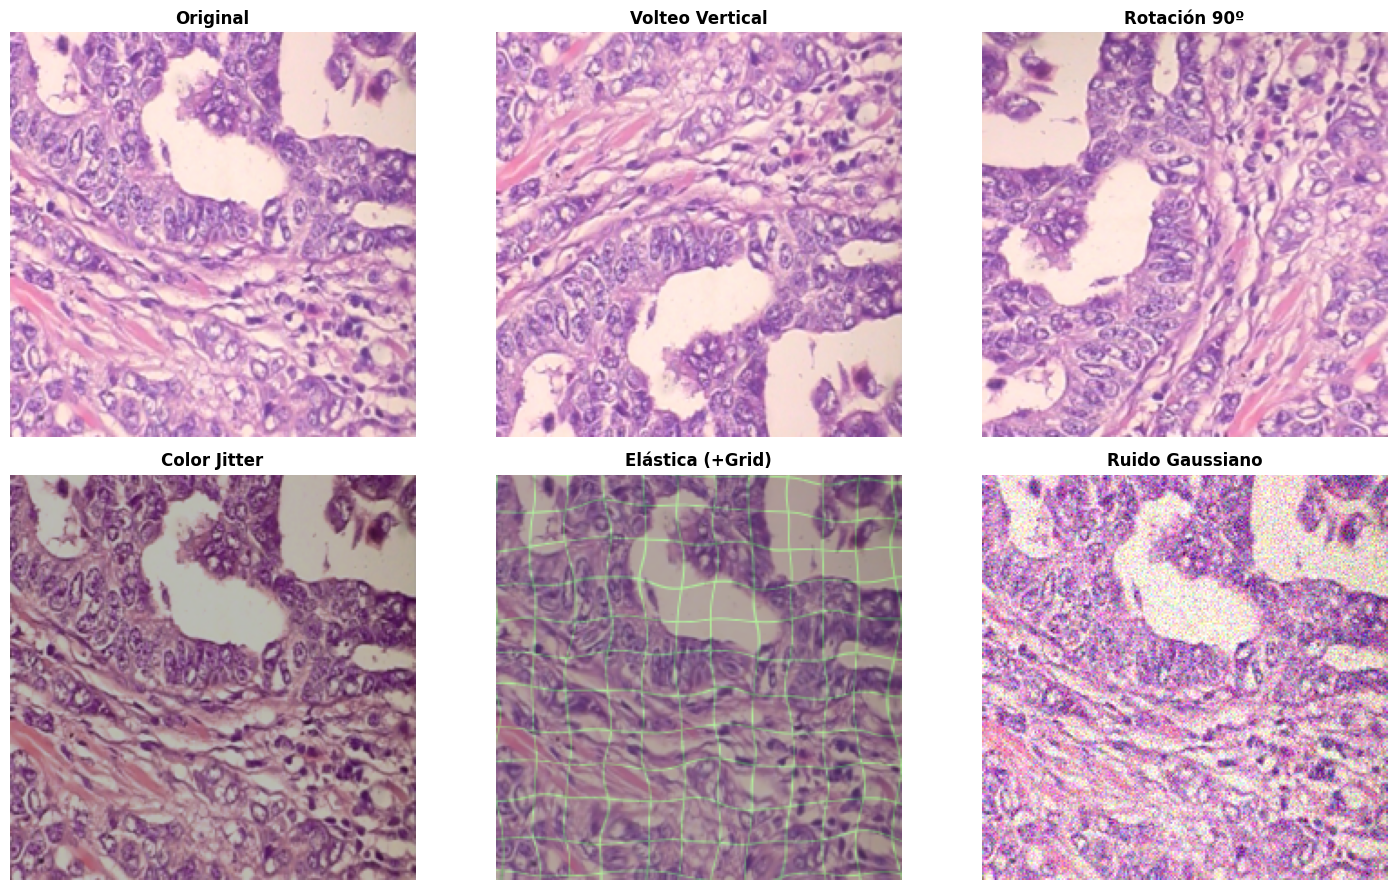

In [6]:
# ==============================================================================
# 4. DEMOSTRACIÓN TÉCNICA DE AUMENTACIONES
# ==============================================================================
# Visualización de los efectos de las transformaciones geométricas y elásticas.

# Cargar imagen aleatoria
rand_file = random.choice(files)
data = np.load(os.path.join(DATA_PATH, rand_file))
key = list(data.keys())[0]
img_array = data[key]
rand_idx = random.randint(0, img_array.shape[0] - 1)

# Imagen Original (PIL)
img_raw = img_array[rand_idx]
if img_raw.max() <= 1.0: img_raw = (img_raw * 255).astype(np.uint8)
else: img_raw = img_raw.astype(np.uint8)
original_pil = Image.fromarray(img_raw).resize((224, 224))

# --- Transformaciones ---

# A. Geométricas Básicas
img_flip_v = F.vflip(original_pil)
img_rot = F.rotate(original_pil, 90)

# B. Color Jitter
jitter = T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.05)
img_color = jitter(original_pil)

# C. Ruido Gaussiano (Advanced)
def add_noise(img):
    img_np = np.array(img, dtype=np.float32) / 255.0
    noise = np.random.normal(0, 0.12, img_np.shape) # Sigma visible para demo
    noisy = np.clip(img_np + noise, 0, 1)
    return Image.fromarray((noisy * 255).astype(np.uint8))
img_noise = add_noise(original_pil)

# D. Deformación Elástica + Grid (Advanced)
def apply_elastic_with_grid(img):
    # 1. Grid sintético
    grid_img = Image.new('RGB', img.size, (0, 0, 0))
    draw = ImageDraw.Draw(grid_img)
    step = 20
    for x in range(0, img.width, step): draw.line((x, 0, x, img.height), fill=(0, 255, 0), width=1)
    for y in range(0, img.height, step): draw.line((0, y, img.width, y), fill=(0, 255, 0), width=1)
    
    t_img = F.to_tensor(img)
    t_grid = F.to_tensor(grid_img)

    # Configuración Visual Exagerada
    elastic_transformer = T.ElasticTransform(
        alpha=250.0, 
        sigma=10.0, 
        interpolation=T.InterpolationMode.BILINEAR,
        fill=0 
    )
    
    # Padding 'Reflect' para evitar bordes negros
    pad = 50
    t_img_padded = F.pad(t_img, pad, padding_mode='reflect')
    t_grid_padded = F.pad(t_grid, pad, padding_mode='reflect')
    
    seed = np.random.randint(2147483647)
    torch.manual_seed(seed); def_img_padded = elastic_transformer(t_img_padded)
    torch.manual_seed(seed); def_grid_padded = elastic_transformer(t_grid_padded)
    
    # Recortar al centro
    def_img = F.center_crop(def_img_padded, (224, 224))
    def_grid = F.center_crop(def_grid_padded, (224, 224))
    
    return Image.blend(F.to_pil_image(def_img), F.to_pil_image(def_grid), alpha=0.3)

img_elastic = apply_elastic_with_grid(original_pil)

# --- Plot (2 Filas x 3 Columnas) ---
fig, axes = plt.subplots(2, 3, figsize=(15, 9)) 

images = [original_pil, img_flip_v, img_rot, img_color, img_elastic, img_noise]
titles = ["Original", "Volteo Vertical", "Rotación 90º", "Color Jitter", "Elástica (+Grid)", "Ruido Gaussiano"]

for ax, img, title in zip(axes.flatten(), images, titles):
    ax.imshow(img)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.axis("off")

plt.tight_layout()
plt.show()
